In [1]:
x=1

In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

To use sccoda or tasccoda please install ete3 with pip install ete3

In [3]:
%%R
library(edgeR)
library(MAST)

In [4]:
adata = sc.read('../../../pipeline/data/analysis/hlca_healthy_ipf_embed_balanced/adata_final.h5ad')
adata

AnnData object with n_obs × n_vars = 450214 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_leve

In [5]:
macrophages = adata[adata.obs['celltype'] == 'Macrophages'].copy()
macrophages

AnnData object with n_obs × n_vars = 158750 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_leve

In [6]:
ipf_macrophages = macrophages[macrophages.obs['lung_condition_coarse'] == 'IPF'].copy()
ipf_macrophages

AnnData object with n_obs × n_vars = 104045 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_leve

In [7]:
threshold_idx = int(len(ipf_macrophages) * 0.9)
threshold_value = sorted(ipf_macrophages.obs['cell_attn'])[threshold_idx]
threshold_value

0.01770123466849327

In [8]:
ipf_macrophages.obs['group'] = 'all'
ipf_macrophages.obs.loc[ipf_macrophages.obs['cell_attn'] >= threshold_value, 'group'] = 'top'

In [9]:
ipf_macrophages.obs['group'].value_counts()

group
all    93640
top    10405
Name: count, dtype: int64

In [10]:
ipf_macrophages.obs['sample_group'] = ipf_macrophages.obs['sample'].astype('str') + '_' + ipf_macrophages.obs['group']
ipf_macrophages.obs['sample_group'] = ipf_macrophages.obs['sample_group'].astype('category')

In [11]:
ipf_macrophages

AnnData object with n_obs × n_vars = 104045 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_leve

In [12]:
samples_to_exclude = []
for sample in np.unique(ipf_macrophages.obs[['sample_group']]):
    sample_len = len(ipf_macrophages[ipf_macrophages.obs['sample_group'] == sample])
    if sample_len < 10:
        samples_to_exclude.append(sample)

In [13]:
samples_to_exclude

['IPF1_Lin_all',
 'IPF1_Lin_top',
 'IPF2_Lin_all',
 'IPF2_Lin_top',
 'IPF3_Lin_top']

In [14]:
ipf_macrophages = ipf_macrophages[~ipf_macrophages.obs['sample_group'].isin(samples_to_exclude)].copy()
ipf_macrophages

AnnData object with n_obs × n_vars = 104009 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_leve

In [15]:
hlca = sc.read('../../../../snakemake/hlca/5fold/hlca_hyperparam/data/pp/hlca_hvg_pearson.h5ad')
hlca

AnnData object with n_obs × n_vars = 2149684 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_l

In [16]:
hlca.X.data

array([1., 5., 1., ..., 1., 2., 3.], dtype=float32)

In [17]:
ipf_macrophages_genes = sc.AnnData(hlca[ipf_macrophages.obs_names].X)
ipf_macrophages_genes.var_names = hlca[ipf_macrophages.obs_names].var_names
ipf_macrophages_genes.obs = ipf_macrophages.obs
ipf_macrophages_genes.uns = ipf_macrophages.uns
ipf_macrophages_genes.obsm = ipf_macrophages.obsm
ipf_macrophages_genes

AnnData object with n_obs × n_vars = 104009 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_le

In [18]:
ipf_macrophages_genes.X.data

array([ 3.,  4., 14., ...,  1.,  2.,  3.], dtype=float32)

In [19]:
len(np.unique(ipf_macrophages_genes.obs['sample_group']))

126

In [20]:
adata_ = dc.get_pseudobulk(ipf_macrophages_genes, 'sample', 'group', mode='sum', min_cells=-1, min_counts=-1)
adata_                            

AnnData object with n_obs × n_vars = 126 × 1999
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'assay', 'cause_of_death', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'lung_condition', 'mixed_ancestry', 'original_ann_level_5', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'transf_ann_level_3_label', 'lung_condition_coarse', 'split0', 'split1', 'split2', 'split3', 'split4', 'ann_level_3_label_final', 'group', 'celltype', 'sample_group', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

In [21]:
adata_.layers['counts'] = adata_.X.copy()

In [22]:
sc.pp.normalize_total(adata_, target_sum=1e4)
sc.pp.log1p(adata_)
sc.pp.pca(adata_)

In [23]:
adata_.obs["lib_size"] = np.sum(adata_.layers["counts"], axis=1)
adata_.obs["log_lib_size"] = np.log(adata_.obs["lib_size"])

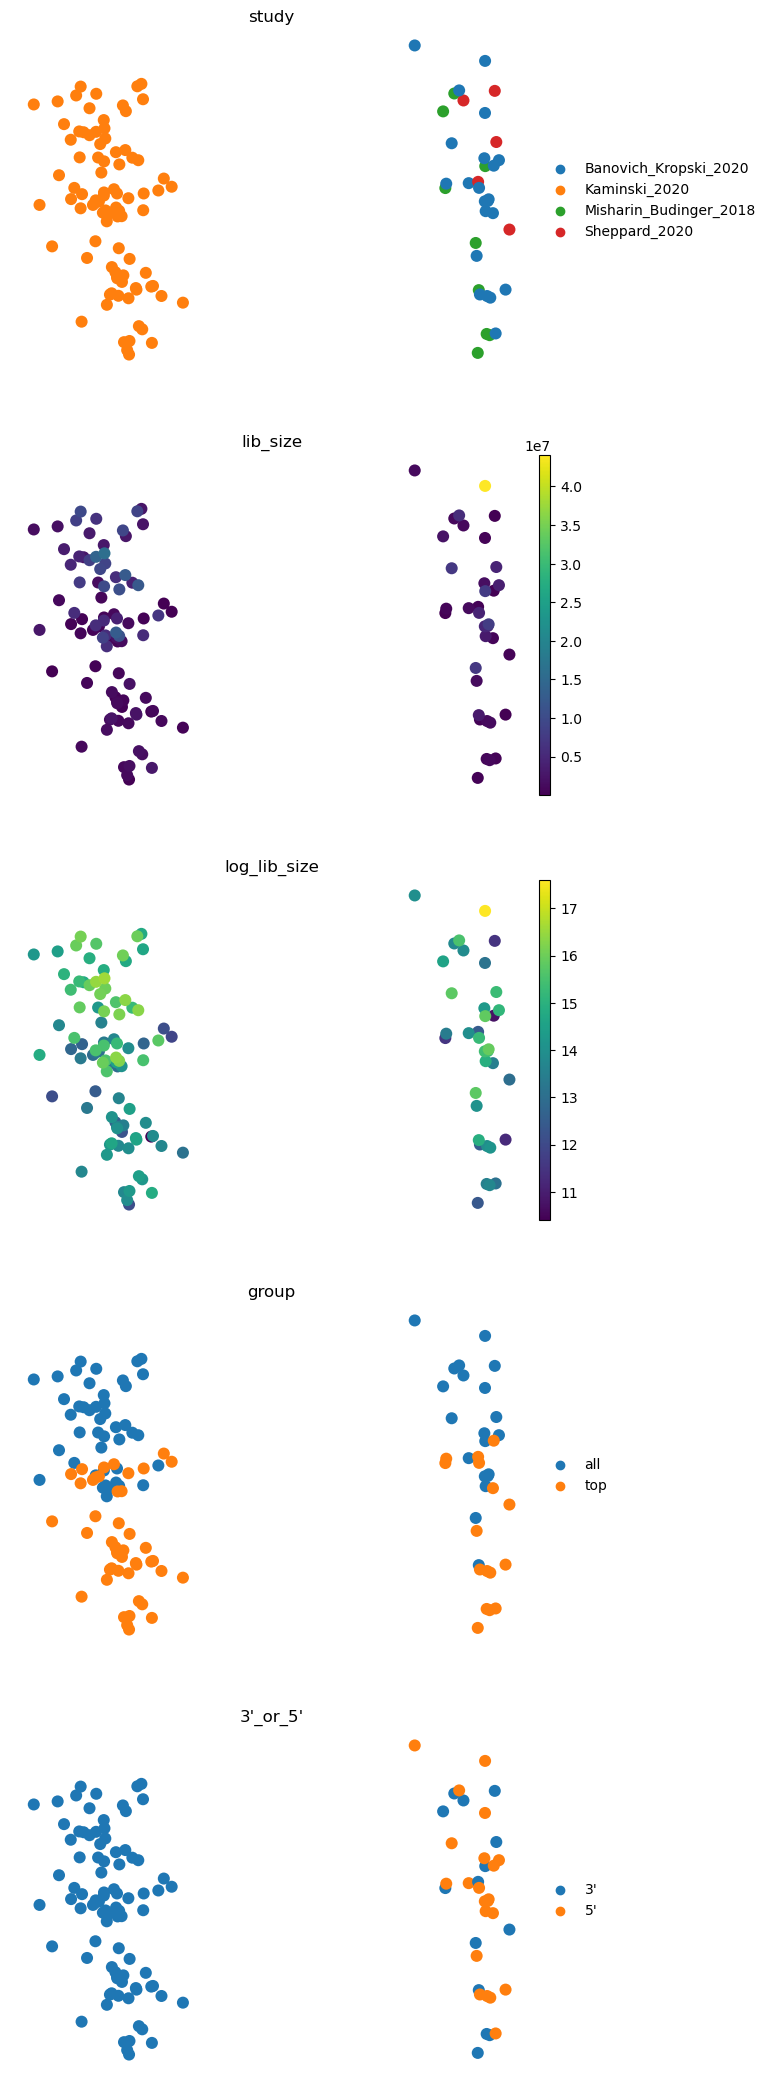

In [24]:
sc.pl.pca(adata_, color=['study', 'lib_size', 'log_lib_size', 'group', "3'_or_5'"], ncols=1, size=300, frameon=False)

In [25]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$group)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # will add study covariate to the design matrix as there are still some batch effects
    group <- colData(adata_)$group
    replicate <- colData(adata_)$sample
    study <- colData(adata_)$study
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + study)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [26]:
adata_.X = adata_.layers['counts'].copy()
adata_.X

array([[8.800e+01, 1.180e+02, 2.620e+02, ..., 3.906e+03, 0.000e+00,
        9.200e+01],
       [4.800e+01, 4.700e+01, 2.000e+02, ..., 2.054e+03, 4.000e+00,
        6.100e+01],
       [7.800e+01, 2.740e+02, 1.860e+02, ..., 3.722e+03, 1.100e+01,
        6.400e+01],
       ...,
       [1.000e+00, 5.700e+01, 2.800e+01, ..., 5.620e+02, 0.000e+00,
        4.000e+00],
       [5.000e+00, 1.570e+02, 1.800e+01, ..., 6.400e+02, 0.000e+00,
        4.000e+00],
       [0.000e+00, 8.000e+00, 0.000e+00, ..., 1.700e+01, 0.000e+00,
        1.000e+00]], dtype=float32)

In [27]:
macro = sc.AnnData(adata_.X, obs=adata_.obs[['group', 'sample_group', 'study', 'sample']])
macro.var_names = adata_.var_names
macro.obs['sample'] = macro.obs['sample'].str.replace('-', '_')
macro

AnnData object with n_obs × n_vars = 126 × 1999
    obs: 'group', 'sample_group', 'study', 'sample'

In [28]:
macro = macro.copy()
macro

AnnData object with n_obs × n_vars = 126 × 1999
    obs: 'group', 'sample_group', 'study', 'sample'

In [29]:
%%time
%%R -i macro
outs <-fit_model(macro)

[1] "Dimensions before subsetting:"
[1] 1999  126
[1] ""
[1] "Dimensions after subsetting:"
[1] 933 126
[1] ""
CPU times: user 3.31 s, sys: 290 ms, total: 3.6 s
Wall time: 3.79 s


In [30]:
%%R
fit <- outs$fit
y <- outs$y

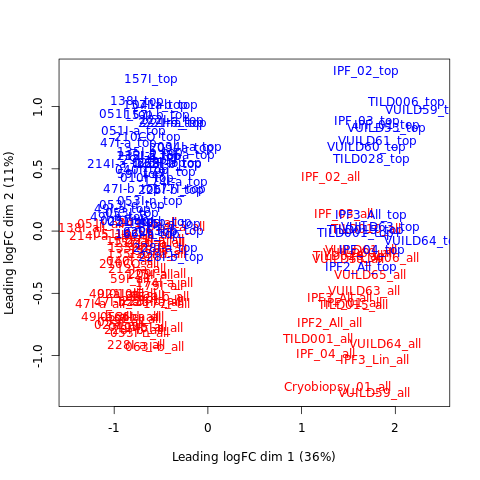

In [31]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "all", "red", "blue"))

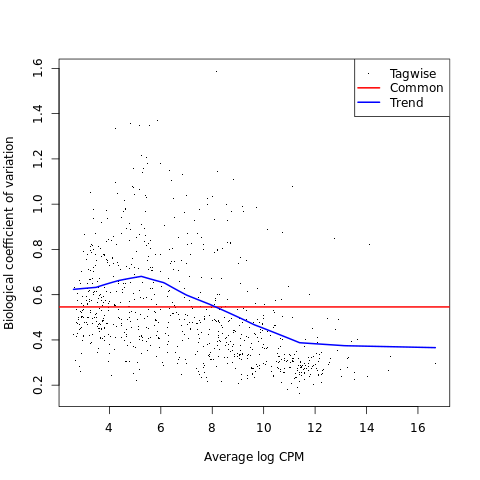

In [32]:
%%R
plotBCV(y)

In [33]:
%%R
colnames(y$design)

[1] "groupall"                    "grouptop"                   
[3] "studyKaminski_2020"          "studyMisharin_Budinger_2018"
[5] "studySheppard_2020"         


In [34]:
%%R -o tt
myContrast <- makeContrasts("grouptop - groupall", levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [35]:
tt.shape

(933, 5)

In [36]:
tt[:5]

,logFC,logCPM,F,PValue,FDR
ENSG00000007264,2.026804,7.204628,178.410198,6.161968e-26,5.749117e-23
ENSG00000110077,-1.239048,8.297278,153.496495,1.400278e-23,6.532297e-21
ENSG00000149131,-2.199223,7.590806,131.551354,2.538911e-21,7.896012e-19
ENSG00000110092,2.394492,4.259072,129.213150,4.535867e-21,1.057991e-18
ENSG00000143320,3.499534,5.411298,124.831558,1.365423e-20,2.547880e-18


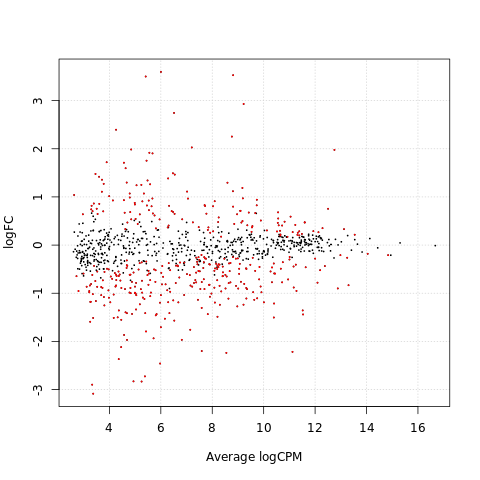

In [37]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

In [38]:
tt_sign = tt[tt['FDR'] < 0.01]
tt_sign

,logFC,logCPM,F,PValue,FDR
ENSG00000007264,2.026804,7.204628,178.410198,6.161968e-26,5.749117e-23
ENSG00000110077,-1.239048,8.297278,153.496495,1.400278e-23,6.532297e-21
ENSG00000149131,-2.199223,7.590806,131.551354,2.538911e-21,7.896012e-19
ENSG00000110092,2.394492,4.259072,129.213150,4.535867e-21,1.057991e-18
ENSG00000143320,3.499534,5.411298,124.831558,1.365423e-20,2.547880e-18
...,...,...,...,...,...
ENSG00000102575,0.196762,10.647646,8.974428,3.294613e-03,7.841515e-03
ENSG00000123358,-0.439639,6.667930,8.823266,3.559291e-03,8.449921e-03
ENSG00000248323,-0.622588,5.480741,8.754862,3.686179e-03,8.728947e-03
ENSG00000102879,0.367273,6.267579,8.716461,3.759447e-03,8.879910e-03


In [39]:
up_genes = list(tt_sign[tt_sign['logFC'] > 1.5].index)
len(up_genes)

16

In [40]:
macrophages_genes = {
    'SPP1': 'ENSG00000118785',
    'LIPA': 'ENSG00000107798',
    'LPL': 'ENSG00000175445',
    'FDX1': 'ENSG00000137714',
    'SPARC': 'ENSG00000113140',
    'MATK': 'ENSG00000007264',
    'GPC4': 'ENSG00000076716',
    'PALLD': 'ENSG00000129116',
    'MMP7': 'ENSG00000137673',
    'MMP9': 'ENSG00000100985',
    'CHIT1': 'ENSG00000133063',
    'CSTK': 'ENSG00000143387',
    'CHI3L1': 'ENSG00000133048',
    'CSF1': 'ENSG00000184371',
    'FCMR': 'ENSG00000162894',
    'TIMP3': 'ENSG00000100234',
    'COL22A1': 'ENSG00000169436',
    'SIGLEC15': 'ENSG00000197046',
    'CCL2': 'ENSG00000108691',
}

In [41]:
len(up_genes)

16

In [42]:
len(set(up_genes).intersection(set(macrophages_genes.values())))

6

In [43]:
set(up_genes) - set(macrophages_genes.values())

{'ENSG00000026751',
 'ENSG00000102962',
 'ENSG00000110092',
 'ENSG00000125735',
 'ENSG00000143320',
 'ENSG00000151789',
 'ENSG00000159674',
 'ENSG00000164266',
 'ENSG00000166165',
 'ENSG00000262406'}

In [44]:
set(up_genes).intersection(set(macrophages_genes.values()))

{'ENSG00000007264',
 'ENSG00000100234',
 'ENSG00000100985',
 'ENSG00000118785',
 'ENSG00000133048',
 'ENSG00000137673'}

In [45]:
tt.to_csv('csv/macrophages_ipf_vs_top_ipf_0+group+study.csv')

In [46]:
import matplotlib_venn

In [47]:
len(set(macrophages_genes.values()).intersection(set(hlca.var_names)))

15

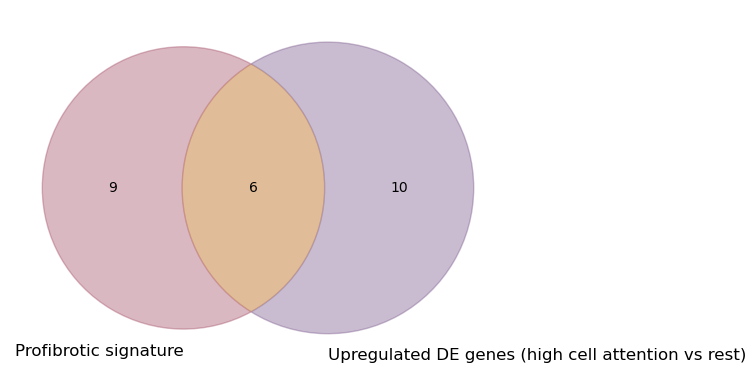

In [48]:
# from https://colorswall.com/palette/70049
v = matplotlib_venn.venn2(subsets = (9, 10, 6), set_labels = ('Profibrotic signature', 'Upregulated DE genes (high cell attention vs rest)'))
v.get_patch_by_id('100').set_color('#a44e66')
v.get_patch_by_id('010').set_color('#7a588c')
plt.savefig('figures/venn.svg', bbox_inches='tight')

In [49]:
set(macrophages_genes.values()).difference(set(hlca.var_names))

{'ENSG00000076716', 'ENSG00000137714', 'ENSG00000169436', 'ENSG00000197046'}

In [50]:
len(macrophages_genes)

19